<a href="https://colab.research.google.com/github/dddonghwa/deep-learning-with-python/blob/main/ch5_02_pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 5.3 사전 훈련된 컨브넷 사용하기

#### 사전 훈련된 네트워크(pretrained network)란?
대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크,  
학습된 데이터셋이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있음  
데이터셋 예) ImageNet

#### 예제
- 모델 : VGG16
- 훈련된 데이터셋 : ImageNet (1400만개의 레이블된 이미지와 1000개의 클래스로 구성)

#### 사전 훈련된 네트워크를 사용하는 방법
1) 특성 추출 Feature Extraction  
2) 미세 조정 Fine Tuning

### 5.3.1 특성 추출
사전에 학습된 네트워크의 표현(representation)을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아내는 것

사전 훈련된 네트워크 = 합성곱 기반 층(convolutional base) + <U>완전 연결 분류기(FC classifier)</U>  
새로 학습할 네트워크 = 합성곱 기반 층 + <U>새로운 분류기</U>  

#### 분류기를 새로 학습하는 이유?  
모델이 훈련한 클래스 집합에 특화되어 있기 때문에  
분류기는 이미지에 어떤 클래스가 존재할 확률에 관한 정보를 담고 있는데, 해당 클래스가 우리가 얻고자하는 클래스가 아닌 경우가 많다.   
또한 분류가 아닌 문제(예.객체 탐지, 이미지 분할 등)이라면 위치 정보를 없애는 완전 연결층 (FC layer)를 제거해야 한다.

#### 합성곱 기반 층의 깊이에 따른 피처들?
모델의 하위층 - 지역적이고 매우 일반적인 특성 예) 엣지, 색깔, 질감 등  
모델의 상위 층 - 추상적인 개념 예) 강아지 눈, 고양이 귀  
새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르다면 전체 합성곱 기반층을 사용하는 것보다 모델의 하위 층 몇개만 특성 추출에 사용하는 것이 좋다.

### 케라스에서 사용 가능한 사전에 학습된 네트워크
VGG16, Xception, Inception V3, ResNet 50 등등 [링크](https://keras.io/api/applications/)

In [ ]:
# 5-16 VGG16 합성곱 기반 층 만들기
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # 초기화할 가중치 체크포인트 지정
                  include_top=False, # 최상위 FC레이어 포함/비포함 여부(default=True)
                  input_shape=(150,150,3)) 

conv_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

`conv_base`를 통과한 출력은 (4,4,512) 크기를 갖음

#### 1) 데이터 증식을 사용하지 않은 빠른 특성 추출  
새로운 이미지를 `conv_base`에 입력해서 나온 출력을 numpy 배열로 저장 → 독립된 FC layer에 입력으로 사용하여 분류기 학습시킴 
- 새로운 이미지 전체를 `conv_base`에 한번만 입력하면 되기 때문에 빠르고 비용이 적게 듬 
- 하지만 데이터 증식은 사용할 수 없음

#### 2) 데이터 증식을 통한 특성 추출 
`conv_base` 모델 위에 Dense 층을 쌓아 확장 → 입력 데이터에서 end-to-end로 전체 모델을 실행
- 모델에 노출된 모든 이미지가 매번 `conv_base`를 통과하기 때문에 데이터 증식 사용 가능
- 하지만 1)보다 비용 많이 듬

__Q.데이터 증식 가능 여부 이유를 잘 모르겠음, 결국 새로운 이미지를 모두 conv_base에 통과시키는 것 아닌가?__  
A. 책에서 데이터증식을 사용하는 이유는 학습동안 같은 이미지 한번이상 절대 보지 않겠다는 의도라고 하고 있습니다. 1) 방법도 증식을 해서 conv net을 통과 시키고 저장해서 사용하면 되겠지만 이렇게 해서는 같은 이미지를 한번 이상 보지 않는다는 의도를 지킬 수가 없습니다. 단지 그냥 데이터 셋이 더 커진것 뿐입니다. 2)는 배치를 구성한 다음 실시간으로 배치에 포함된 이미지를 무작위로 바꿔버리기 때문에 학습동안 같은 이미지가 입력되는 경우가 없어지게 되는 것입니다. [tensorflowKR 페이스북](https://www.facebook.com/groups/TensorFlowKR/permalink/823681491306244/?comment_id=824915164516210&reply_comment_id=826293474378379)

### 1) 데이터 증식을 사용하지 않은 빠른 특성 추출

In [ ]:
# zip 파일 압축 풀기
import zipfile
    	
dataset_zip = zipfile.ZipFile('/content/dataset_small.zip')
dataset_zip.extractall('/content/')

dataset_zip.close()

In [ ]:
# [CAUTION] it takes around 10 mins
# 코드 5-17 사전 훈련된 conv_base을 사용한 특성 추출하기
import os
import os.path as osp
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './dataset_small/'
train_dir = osp.join(base_dir, 'train')
val_dir = osp.join(base_dir, 'val')
test_dir = osp.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size=20

def extract_feature(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4,4,512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(
      train_dir,
      target_size=(150,150),
      class_mode='binary',
      batch_size=batch_size
  )
  i = 0 
  for inputs_batch, labels_batch in generator :
    features_batch = conv_base.predict(inputs_batch)
    features[i*batch_size:(i+1)*batch_size] = features_batch
    labels[i*batch_size:(i+1)*batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count :
      break

  return features, labels

train_features, train_labels = extract_feature(train_dir, 2000)
val_features, val_labels = extract_feature(val_dir, 1000)
test_features, test_labels = extract_feature(test_dir, 1000)



Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
train_features = train_features.reshape((2000,4*4*512))
test_features = test_features.reshape((1000, 4*4*512))
val_features = val_features.reshape((1000, 4*4*512))

In [ ]:
# save 
np.save('/content/train_features.npy', train_features)
np.save('/content/test_features.npy', test_features)
np.save('/content/val_features.npy', val_features)

FC layer를 새롭게 정의하고(드롭아웃 포함) 저장된 데이터와 레이블을 사용하여 훈련

In [ ]:
# 5-16 FC layer 정의하고 훈련하기

from keras import models, layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer = optimizers.RMSprop(2e-5),
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
          validation_data=(val_features, val_labels),
          epochs=30,
          batch_size=20)

Epoch 1/30
100/100 [==============================] - 4s 32ms/step - loss: 0.6365 - accuracy: 0.6450 - val_loss: 0.4204 - val_accuracy: 0.8490
Epoch 2/30
100/100 [==============================] - 3s 29ms/step - loss: 0.4308 - accuracy: 0.7995 - val_loss: 0.3253 - val_accuracy: 0.8890
Epoch 3/30
100/100 [==============================] - 3s 32ms/step - loss: 0.3663 - accuracy: 0.8440 - val_loss: 0.2810 - val_accuracy: 0.9030
Epoch 4/30
100/100 [==============================] - 3s 33ms/step - loss: 0.3185 - accuracy: 0.8650 - val_loss: 0.2520 - val_accuracy: 0.9140
Epoch 5/30
100/100 [==============================] - 3s 32ms/step - loss: 0.2853 - accuracy: 0.8880 - val_loss: 0.2315 - val_accuracy: 0.9220
Epoch 6/30
100/100 [==============================] - 3s 30ms/step - loss: 0.2609 - accuracy: 0.9025 - val_loss: 0.2122 - val_accuracy: 0.9330
Epoch 7/30
100/100 [==============================] - 3s 30ms/step - loss: 0.2523 - accuracy: 0.8985 - val_loss: 0.1981 - val_accuracy: 0.9380

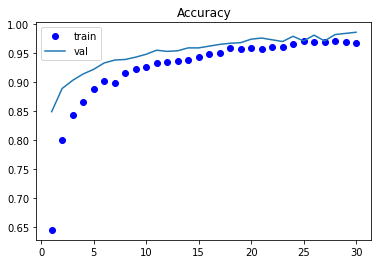

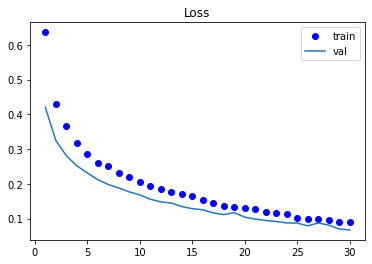

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history_dict):
  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = np.arange(1, len(acc)+1)
  plt.plot(epochs, acc, 'bo',label='train')
  plt.plot(epochs, val_acc, label='val')
  plt.title('Accuracy')
  plt.legend()
  plt.show()

  plt.plot(epochs, loss, 'bo', label='train')
  plt.plot(epochs, val_loss, label='val')
  plt.title('Loss')
  plt.legend()
  plt.show()


plot_history(history.history)

### 2) 데이터 증식을 사용한 특성 추출
데이터




In [ ]:
# 5-14 사전 훈련된 합성곱 기반 층을 사용한 특성 추출하기
import os
import numpy as np
import keras.preprocessing.image import ImageDataGenerator